## Library settings

In [ ]:
!pip install PyPDF2
!pip install langchain
!pip install openai
!pip install tiktoken
!pip install faiss-cpu
!pip install pytesseract
!pip install opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 49.1 MB/s eta 0:00:00


In [ ]:
from PyPDF2 import PdfReader

import langchain
from langchain.text_splitter import CharacterTextSplitter
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import LlamaCpp
from langchain.vectorstores import Qdrant, FAISS
from langchain.embeddings import SentenceTransformerEmbeddings
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chat_models import ChatOpenAI
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI
from langchain.callbacks import get_openai_callback
from langchain.document_loaders import PyPDFLoader


# Fix for some new weird "no attribute 'verbose'" bug https://github.com/hwchase17/langchain/issues/4164
langchain.verbose = False

## Mounting Drive.
If you don't have the "Turing 2023" folder at your "My Drive" you can add a direct link. With that you can access the uploaded pdfs

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
%cd gdrive/MyDrive

/content/gdrive/MyDrive


In [ ]:
import os
os.chdir("/content/gdrive/My Drive/Turing 2023/AnglophoneChile newspaper PDFs/Star of Chile")


In [ ]:
API='sk-yourkeyopenai'

##Collecting editions

In [ ]:
import pandas as pd
import os

In [ ]:
list_files = os.listdir()

docs_list = pd.DataFrame({
    'name': list_files,
    'shipping report': [None] * len(list_files)
})

print(docs_list)

                  name shipping report
0   PE0001106_0001.pdf            None
1   PE0001106_0007.pdf            None
2   PE0001106_0008.pdf            None
3   PE0001106_0009.pdf            None
4   PE0001106_0010.pdf            None
..                 ...             ...
82  PE0001106_0003.pdf            None
83  PE0001106_0004.pdf            None
84  PE0001106_0005.pdf            None
85  PE0001106_0006.pdf            None
86  docs_with_data.csv            None

[87 rows x 2 columns]


In [ ]:
questions = [
    "What's the name of the news paper",
    "What's the date, price and volume of that news paper edition?",
    "Show the list of ships in shipping report"
]

### Hints for use:


*   In this line you can select some volume for the QA -> pdf = docs_list['name'][1]
*   In the next cell you would be abble to write a question. It will appear an input winthow like this 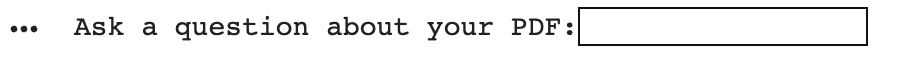

These are some examples that you could use:

*   The shipping report is a table with this columns: Date, Port, Name, Tonnage, Consignees, Cargo. Can you give me the list of names that appear in that table?
*   What is the printing date for this news paper?






In [ ]:
pdf = docs_list['name'][1]

In [ ]:
pdf

'PE0001106_0007.pdf'

In [ ]:
table = 'Date | Port | Name | Tonnage | Consignees | Cargo \n Aug. 23 | Iquique | Reine Blanche... | 1475 | Gmo. Wilms..... | Coal \n " | Mollendo | Invermale....|1337| |Lumber \n " 25 | do | Nelson.... | 1247 | | Coal'

In [ ]:
print(table)

Date | Port | Name | Tonnage | Consignees | Cargo 
 Aug. 23 | Iquique | Reine Blanche... | 1475 | Gmo. Wilms..... | Coal 
 " | Mollendo | Invermale....|1337| |Lumber 
 " 25 | do | Nelson.... | 1247 | | Coal


In [ ]:
prompt= 'The shipping report near page 10 is: . You can find this under the header ARRIVALS OF FOREIGN VESSELS ON WEST COAST, SOUTH AMERICA and above CHARTERS header. Answer in table format with columns Date, Port, Name, Tonnage, Consignees, Cargo. Break line after rows end. An example of this table is: ' + table

In [ ]:
print(prompt)

The shipping report near page 10 is: . You can find this under the header ARRIVALS OF FOREIGN VESSELS ON WEST COAST, SOUTH AMERICA and above CHARTERS header. Answer in table format with columns Date, Port, Name, Tonnage, Consignees, Cargo. Break line after rows end. An example of this table is: Date | Port | Name | Tonnage | Consignees | Cargo 
 Aug. 23 | Iquique | Reine Blanche... | 1475 | Gmo. Wilms..... | Coal 
 " | Mollendo | Invermale....|1337| |Lumber 
 " 25 | do | Nelson.... | 1247 | | Coal


In [ ]:
# extract the text

if pdf is not None:
  pdf_reader = PdfReader(pdf)
  text = ""
  for page in pdf_reader.pages:
      text += page.extract_text()

      # split into chunks
      if text:
        text_splitter = CharacterTextSplitter(
          separator="\n",
          chunk_size=1000,
          chunk_overlap=200,
          length_function=len
        )
        chunks = text_splitter.split_text(text)

      # create embeddings
  embeddings = OpenAIEmbeddings(openai_api_key=API)
  knowledge_base = FAISS.from_texts(chunks, embeddings)

      # show user input
  user_question = input("Ask a question about your PDF:")
  if user_question:
        docs = knowledge_base.similarity_search(user_question)

        llm = OpenAI(model = 'text-davinci-003',temperature=0.1,openai_api_key=API)
        chain = load_qa_chain(llm, chain_type="stuff")
        with get_openai_callback() as cb:
          response = chain.run(input_documents=docs, question=user_question)
          #print(cb)

        print(response)

Ask a question about your PDF:The shipping report near page 10 is: . You can find this under the header ARRIVALS OF FOREIGN VESSELS ON WEST COAST, SOUTH AMERICA and above CHARTERS header. Answer in table format with columns Date, Port, Name, Tonnage, Consignees, Cargo. Break line after rows end. An example of this table is: Date | Port | Name | Tonnage | Consignees | Cargo   Aug. 23 | Iquique | Reine Blanche... | 1475 | Gmo. Wilms..... | Coal   " | Mollendo | Invermale....|1337| |Lumber   " 25 | do | Nelson.... | 1247 | | Coal

Date | Port | Name | Tonnage | Consignees | Cargo
July 28 | Guayaquil | Rialto | 1141 | W.R. Grace & Co. | Lumber
Aug. 21 | Callao | Cadwgan | 1264 | G.C. Kenrick & Co. | Coal
Sept. 25 | do | Clan Slackenzie | 1509 | Cia. Sal. Alemana | Coal
Oct. 2 | Taltal | Arrow | 2971 | English Lomax & Co. | Coal
Oct. 9 | Iquique | Klio | 1571 | W.C. Lyon | Coal
Oct. 12 | Taltal | Beethoven | 1877 | Gmo. Wilms | Coal
Oct. 14 | Iquique | Aconcagua | 1111 | Ballast | Ballast


In [ ]:
!pip install pdf2image

In [ ]:
from pdf2image import convert_from_path

images = convert_from_path(pdf)
images[10]  # first page

In [ ]:
for index, row in docs_list.iterrows():
  pdf = row['name']
  # extract the text

  if pdf is not None:
    pdf_reader = PdfReader(pdf)
    text = ""
    for page in pdf_reader.pages:
        text += page.extract_text()

        # split into chunks
        if text:
          text_splitter = CharacterTextSplitter(
            separator="\n",
            chunk_size=1000,
            chunk_overlap=200,
            length_function=len
          )
          chunks = text_splitter.split_text(text)

        # create embeddings
    embeddings = OpenAIEmbeddings(openai_api_key=API)
    knowledge_base = FAISS.from_texts(chunks, embeddings)

        # show user input
    user_question = prompt
    if user_question:
          docs = knowledge_base.similarity_search(user_question)

          llm = OpenAI(temperature=0.1,openai_api_key=API)
          chain = load_qa_chain(llm, chain_type="stuff")
          with get_openai_callback() as cb:
            response = chain.run(input_documents=docs, question=user_question)
            print(cb)
          row['shipping report']=response
          print(response)

Tokens Used: 1542
	Prompt Tokens: 1537
	Completion Tokens: 5
Successful Requests: 1
Total Cost (USD): $0.03084
 I don't know.
Tokens Used: 1992
	Prompt Tokens: 1810
	Completion Tokens: 182
Successful Requests: 1
Total Cost (USD): $0.03984

Date | Port | Name | Tonnage | Consignees | Cargo 
July 28 | Guayaquil | Rialto | 1141 | W.R. Grace & Co. | Lumber 
Aug. 21 | Callao | Cadwgan | 1264 | G.C. Kenrick & Co. | Coal 
Sept. 25 | do | Clan Slackenzie | 1509 | Cia. Sal. Alemana | Coal 
Oct. 2 | Taltal | Arrow | 2971 | English Lomax & Co. | Coal 
" 9 | Iquique | Klio | 1571 | W.C. Lyon | Coal 
" 12 | Taltal | Beethoven | 1877 | Ballast 
" 14 | Iquique | Aconcagua | 1111 | Conway | Nitrate
Tokens Used: 1763
	Prompt Tokens: 1758
	Completion Tokens: 5
Successful Requests: 1
Total Cost (USD): $0.03526000000000001
 I don't know.
Tokens Used: 1917
	Prompt Tokens: 1760
	Completion Tokens: 157
Successful Requests: 1
Total Cost (USD): $0.03834
 Date | Port | Name | Tonnage | Consignees | Cargo 
July 

Tokens Used: 2112
	Prompt Tokens: 1856
	Completion Tokens: 256
Successful Requests: 1
Total Cost (USD): $0.04224


Date | Port | Name | Tonnage | Consignees | Cargo 
Jan. 19 | Vancouver | Royal Sovereign | - | Soc. Esplotadora de Maderas | Lumber 
Jan. 20 | Coronel | Peru | - | P.S.N.C. | - 
Jan. 20 | Panama | Aconcagua | - | C.S.A.V. | - 
Jan. 21 | Pisagua | Puno | - | P.S.N.C. | - 
Jan. 21 | New York | Celia | - | W.R. Grace & Co. | - 
Jan. 23 | Caleta Buena | South America | - | Duncan Fox & Co. | - 
Jan. 23 | Panama | Chile | - | P.S.N.C. | - 
Jan. 24 | Cardiff | Blanefield | - | G.C. Kenrick & Co. | - 
Jan. 24 | Liverpool | Lord Darby | - | P.S.N.C. | - 
Jan. 24 | Talcahuano | Highlander | - | G.C. Ken
Tokens Used: 2091
	Prompt Tokens: 1835
	Completion Tokens: 256
Successful Requests: 1
Total Cost (USD): $0.04182

Date | Port | Name | Tonnage | Consignees | Cargo 
Feb. 24 | Liverpool | Oravia | - | P.S.N.C. | - 
" | Panamá | Loa | - | Cia.S.A.V. | - 
25 | Pisagua | Puno | - | P.S.

In [ ]:
#docs_list.to_csv('docs_with_data.csv')

In [ ]:
docs_list_processed = pd.read_csv('docs_with_data.csv',header=0,index_col=0)

In [ ]:
print(docs_list_processed['shipping report'].iloc[1])


Date | Port | Name | Tonnage | Consignees | Cargo 
July 28 | Guayaquil | Rialto | 1141 | W.R. Grace & Co. | Lumber 
Aug. 21 | Callao | Cadwgan | 1264 | G.C. Kenrick & Co. | Coal 
Sept. 25 | do | Clan Slackenzie | 1509 | Cia. Sal. Alemana | Coal 
Oct. 2 | Taltal | Arrow | 2971 | English Lomax & Co. | Coal 
" 9 | Iquique | Klio | 1571 | W.C. Lyon | Coal 
" 12 | Taltal | Beethoven | 1877 | Ballast 
" 14 | Iquique | Aconcagua | 1111 | Conway | Nitrate


In [ ]:
docs_list_processed

,name,shipping report
0,PE0001106_0001.pdf,I don't know.
1,PE0001106_0007.pdf,\nDate | Port | Name | Tonnage | Consignees | ...
2,PE0001106_0008.pdf,I don't know.
3,PE0001106_0009.pdf,Date | Port | Name | Tonnage | Consignees | C...
4,PE0001106_0010.pdf,\nDate | Port | Name | Tonnage | Consignees | ...
...,...,...
81,PE0001106_0002.pdf,\nDate | Port | Name | Tonnage | Consignees | ...
82,PE0001106_0003.pdf,\nDate | Port | Name | Tonnage | Consignees | ...
83,PE0001106_0004.pdf,\nDate | Port | Name | Tonnage | Consignees |...
84,PE0001106_0005.pdf,I don't know.
